### Load the data into the program

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def merge_csv_files(file_paths):
    
    dataframes = []

    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dataframes.append(df)


    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df


file_paths = [
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_1.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_2.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_3.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_4.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_5.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_6.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_7.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_8.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_9.csv',
    r'https://raw.githubusercontent.com/BareLevi/Project_Ella_Tomer_Barel/main/Crime_Data_from_2020_to_Present_part_10.csv'
]

df = merge_csv_files(file_paths)


### 1.  Wrangling data

In [196]:
df.dtypes

division_number          int64
date_reported           object
date_occurred           object
area                     int64
area_name               object
reporting_district       int64
part                     int64
crime_code               int64
crime_description       object
modus_operandi          object
victim_age               int64
victim_sex              object
victim_descent          object
premise_code           float64
premise_description     object
weapon_code            float64
weapon_description      object
status                  object
status_description      object
crime_code_1           float64
crime_code_2           float64
crime_code_3           float64
crime_code_4           float64
location                object
cross_street            object
latitude               float64
longitude              float64
dtype: object

#### 1.1 Noisy data
- Boxplot all numberic columns to check for exceptions


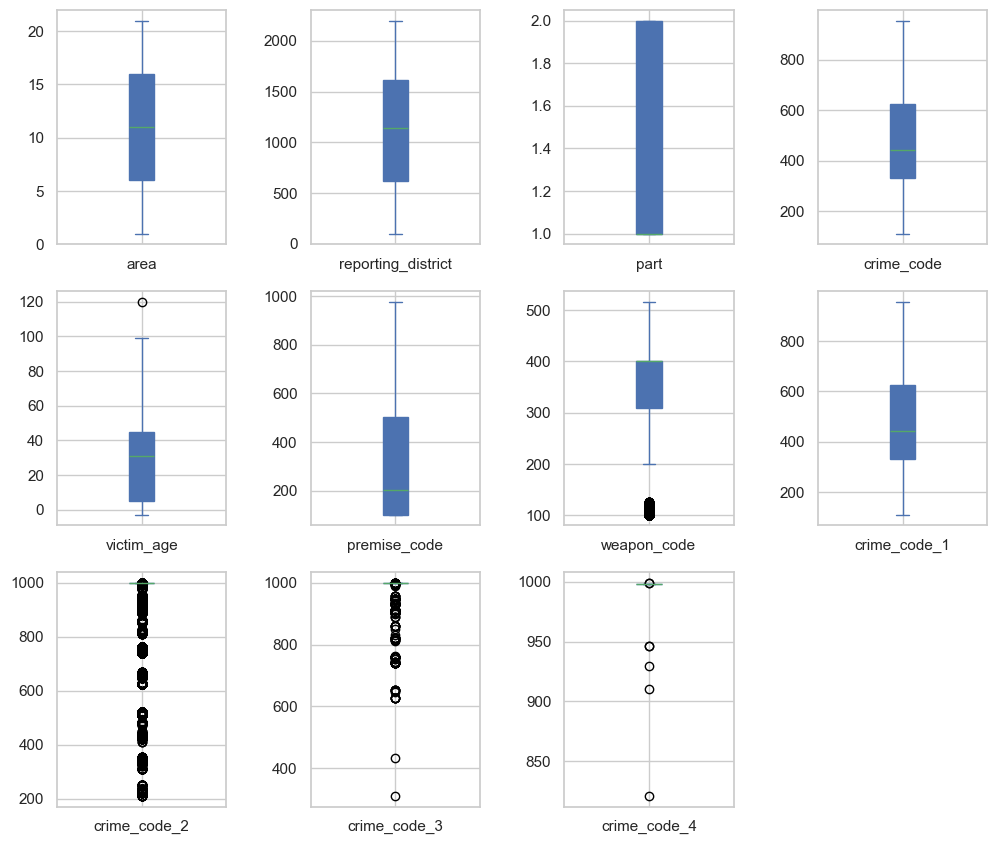

In [197]:
df_to_plot = df.drop(columns=['latitude', 'longitude', 'division_number'])
df_to_plot = df_to_plot.select_dtypes(include=np.number)
df_to_plot.plot(subplots=True, layout=(4, 4), kind='box', figsize=(12, 14), patch_artist=True)
plt.subplots_adjust(wspace=0.5)
plt.show()

ניתן לראות שלמעט העמודות קוד הפשע 2-4, אפשר מתארות יש נו קוד פשע נוסף שקשור לכן הגיוני שיש ערכים חסרים. גם בקוד הנשק הגיוני שיהיו חריגים מכייון שלא כל כל פשע התבצע בעזרת נשק.ניתן לראות שיש הרבה נתונים סביב האפס בעמודות הגילאים נבדוק זאת לעומק

#### 1.2  Checking the column victim_age

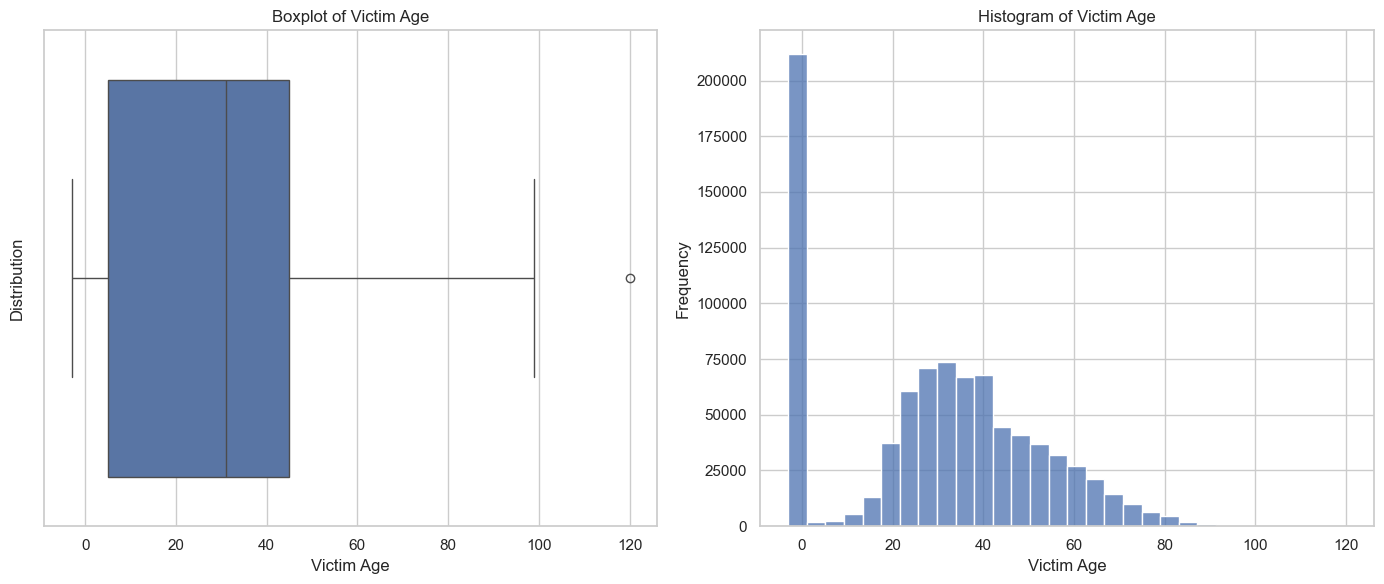

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(ax=axes[0], x='victim_age', data=df)
axes[0].set_title('Boxplot of Victim Age')
axes[0].set_xlabel('Victim Age')
axes[0].set_ylabel('Distribution')


sns.histplot(ax=axes[1], x='victim_age', data=df, kde=False, bins=30)
axes[1].set_title('Histogram of Victim Age')
axes[1].set_xlabel('Victim Age')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

ניתן לראות שבאופן מסויים כנראה במקום לעשות ערכים חסרים הזינו 0

In [199]:
filtered_data = df[df['victim_age'] == 0]
crime_description_counts = filtered_data['crime_description'].value_counts()

crime_description_counts.head(20)


crime_description
VEHICLE - STOLEN                                            91191
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             18467
BURGLARY                                                    16270
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    13813
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     12756
ROBBERY                                                      5782
THEFT PLAIN - PETTY ($950 & UNDER)                           5683
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     5503
TRESPASSING                                                  4935
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     4657
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                   2858
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)                     2773
OTHER MISCELLANEOUS CRIME                                    2235
DISCHARGE FIREARMS/SHOTS FIRED                               1938
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT            

ניתן לראות שיש המון ערכים ששווים ל0 בעמודת הגילאים לא נהמר להורידם מכייון שהם עדייין פשעים שקרו למעט זה נראה שהנותנים תקינים

### 2.  Creating relevant columns

##### 2.1 Convert columns to data time

In [200]:
df['date_occurred'] = pd.to_datetime(df['date_occurred'])
df['date_reported'] = pd.to_datetime(df['date_reported'])


##### 2.2 Creating a column by seasons

In [201]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
df['seasons_occurred'] = df['date_occurred'].dt.month.apply(get_season)

##### 2.3 Creating a column by during the day

In [202]:
def categorize_time(datetime):
    hour = datetime.hour
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Noon'
    elif 16 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
df['day_time'] = df['date_occurred'].apply(categorize_time)

##### 2.4 Creating columns by hour,year and day name

In [203]:
df['hour_occurred'] = df['date_occurred'].dt.hour
df['day_of_week'] = df['date_occurred'].dt.day_name()
df['year_occurred'] = df['date_occurred'].dt.year

##### 2.5 Creating column by age description

In [204]:
def age_category(age):
        age = int(age)
        if age > 0 and age < 10:
            return "child"
        elif age >= 10 and age < 18:
            return "teenager"
        elif age >= 18 and age < 60:
            return "adult"
        elif age >= 60:
            return "old"
        else:    
            return "unknown"


df["age_description"] = df["victim_age"].apply(age_category)

##### 2.6 Creating a column to classify the type of weapon if any

In [205]:
def classify_weapon(weapon_description):
    firearm_keywords = ['PISTOL', 'REVOLVER', 'RIFLE', 'SHOTGUN', 'FIREARM', 'GUN', 'ASSAULT WEAPON', 'MAC', 'UZI', 'HECKLER & KOCH', 'EXPLOXIVE DEVICE', 'AUTOMATIC WEAPON', 'SEMI-AUTOMATIC', 'STARTER PISTOL', 'M1-1', 'M-14', 'BOMB', 'BOMB THREAT']
    sharp_keywords = ['KNIFE', 'SWORD', 'BLADE', 'SCISSORS', 'AXE', 'SCREWDRIVER', 'DIRK', 'DAGGER', 'CLEAVER', 'RAZOR', 'ICE PICK', 'BOWIE KNIFE', 'STRAIGHT RAZOR', 'OTHER CUTTING INSTRUMENT', 'UNKNOWN TYPE CUTTING INSTRUMENT']
    vehicle_keywords = ['VEHICLE']
    fire_bomb_keywords = ['FIRE', 'EXPLOXIVE DEVICE']
    threat_keywords = ['VERBAL THREAT', 'DEMAND NOTE', 'BOMB THREAT']
    improvised_keywords = ['ROCK', 'THROWN OBJECT', 'BLUNT INSTRUMENT', 'BOTTLE', 'CLUB', 'BAT', 'PIPE', 'STICK', 'HAMMER', 'GLASS', 'BRICK', 'BOARD', 'BELT', 'CHAIN', 'MARTIAL ARTS', 'CONCRETE BLOCK', 'SIMULATED GUN', 'MACE', 'PEPPER SPRAY', 'TOY GUN', 'SYRINGE', 'LIQUOR', 'DRUGS', 'FIXED OBJECT', 'BLACKJACK', 'RELIC FIREARM', 'AIR PISTOL', 'CAUSTIC CHEMICAL', 'POISON', 'BRASS KNUCKLES', 'TIRE IRON', 'DOG/ANIMAL (SIC ANIMAL ON)', 'SCALDING LIQUID', 'ROPE/LIGATURE', 'BOW AND ARROW']
    physical_keywords = ['STRONG-ARM', 'HANDS', 'FIST', 'FEET', 'BODILY FORCE', 'PHYSICAL PRESENCE']
    
    if pd.isna(weapon_description):
         if pd.isna(weapon_description):
            return np.nan
    
    if 'UNKNOWN WEAPON' in weapon_description or 'OTHER WEAPON' in weapon_description:
        return 'Unknown Weapon'
    if any(keyword in weapon_description for keyword in firearm_keywords):
        return 'firearm'
    elif any(keyword in weapon_description for keyword in sharp_keywords):
        return 'sharp weapon'
    elif any(keyword in weapon_description for keyword in vehicle_keywords):
        return 'vehicles'
    elif any(keyword in weapon_description for keyword in fire_bomb_keywords):
        return 'fire and bombs'
    elif any(keyword in weapon_description for keyword in threat_keywords):
        return 'threats'
    elif any(keyword in weapon_description for keyword in improvised_keywords):
        return 'improvised weapon'
    elif any(keyword in weapon_description for keyword in physical_keywords):
        return 'Physical strength'
    else:
        return 'OTHER'


df['weapon_category'] = df['weapon_description'].apply(classify_weapon)

In [206]:
df.dtypes

division_number                 int64
date_reported          datetime64[ns]
date_occurred          datetime64[ns]
area                            int64
area_name                      object
reporting_district              int64
part                            int64
crime_code                      int64
crime_description              object
modus_operandi                 object
victim_age                      int64
victim_sex                     object
victim_descent                 object
premise_code                  float64
premise_description            object
weapon_code                   float64
weapon_description             object
status                         object
status_description             object
crime_code_1                  float64
crime_code_2                  float64
crime_code_3                  float64
crime_code_4                  float64
location                       object
cross_street                   object
latitude                      float64
longitude   

In [207]:
earliest_date = df['date_occurred'].min()
latest_date = df['date_occurred'].max()

print(f"The earliest date is: {earliest_date}")
print(f"The latest date is: {latest_date}")

The earliest date is: 2020-01-01 00:01:00
The latest date is: 2023-12-04 23:00:00


### אלימות פיזית ילדים ונערים

In [208]:
relevant_crimes = [
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT',"BATTERY - SIMPLE ASSAULT","ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAUL",
    "OTHER ASSAULT"
    
    
]

Under_age_18_df = df[(df["age_description"] == "child") | (df["age_description"] == "teenager")]
Under_age_18_df = Under_age_18_df[Under_age_18_df['crime_description'].isin(relevant_crimes)]









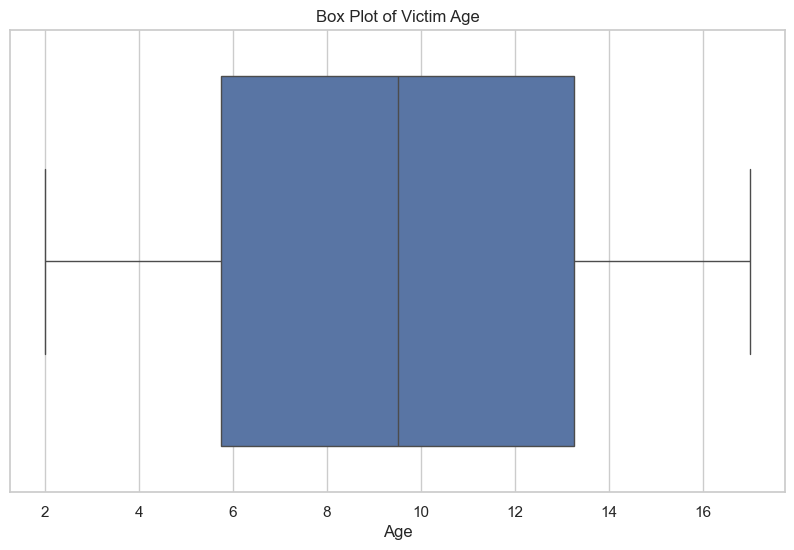

In [209]:
age_counts = Under_age_18_df['victim_age'].value_counts().reset_index()
age_counts.columns = ['victim_age', 'count']

plt.figure(figsize=(10,6))
sns.boxplot(x=age_counts["victim_age"])
plt.title('Box Plot of Victim Age')
plt.xlabel('Age')
plt.show()

In [210]:
child_df = Under_age_18_df[Under_age_18_df["age_description"] == "child"]
child_df_place_count = child_df['premise_description'].value_counts().reset_index()
child_df_place_count.columns = ["place_description", "amount"]



teenager_df = Under_age_18_df[Under_age_18_df["age_description"] == "teenager"]
teenager_df_place_count = teenager_df['premise_description'].value_counts().reset_index()
teenager_df_place_count.columns = ["place_description", "amount"]




C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\3583144332.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_child_places, x='place_description', y='amount', palette=[color_mapping[place] for place in top_child_places['place_description']])
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\3583144332.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_teenager_places, x='place_description', y='amount', palette=[color_mapping[place] for place in top_teenager_places['place_description']])


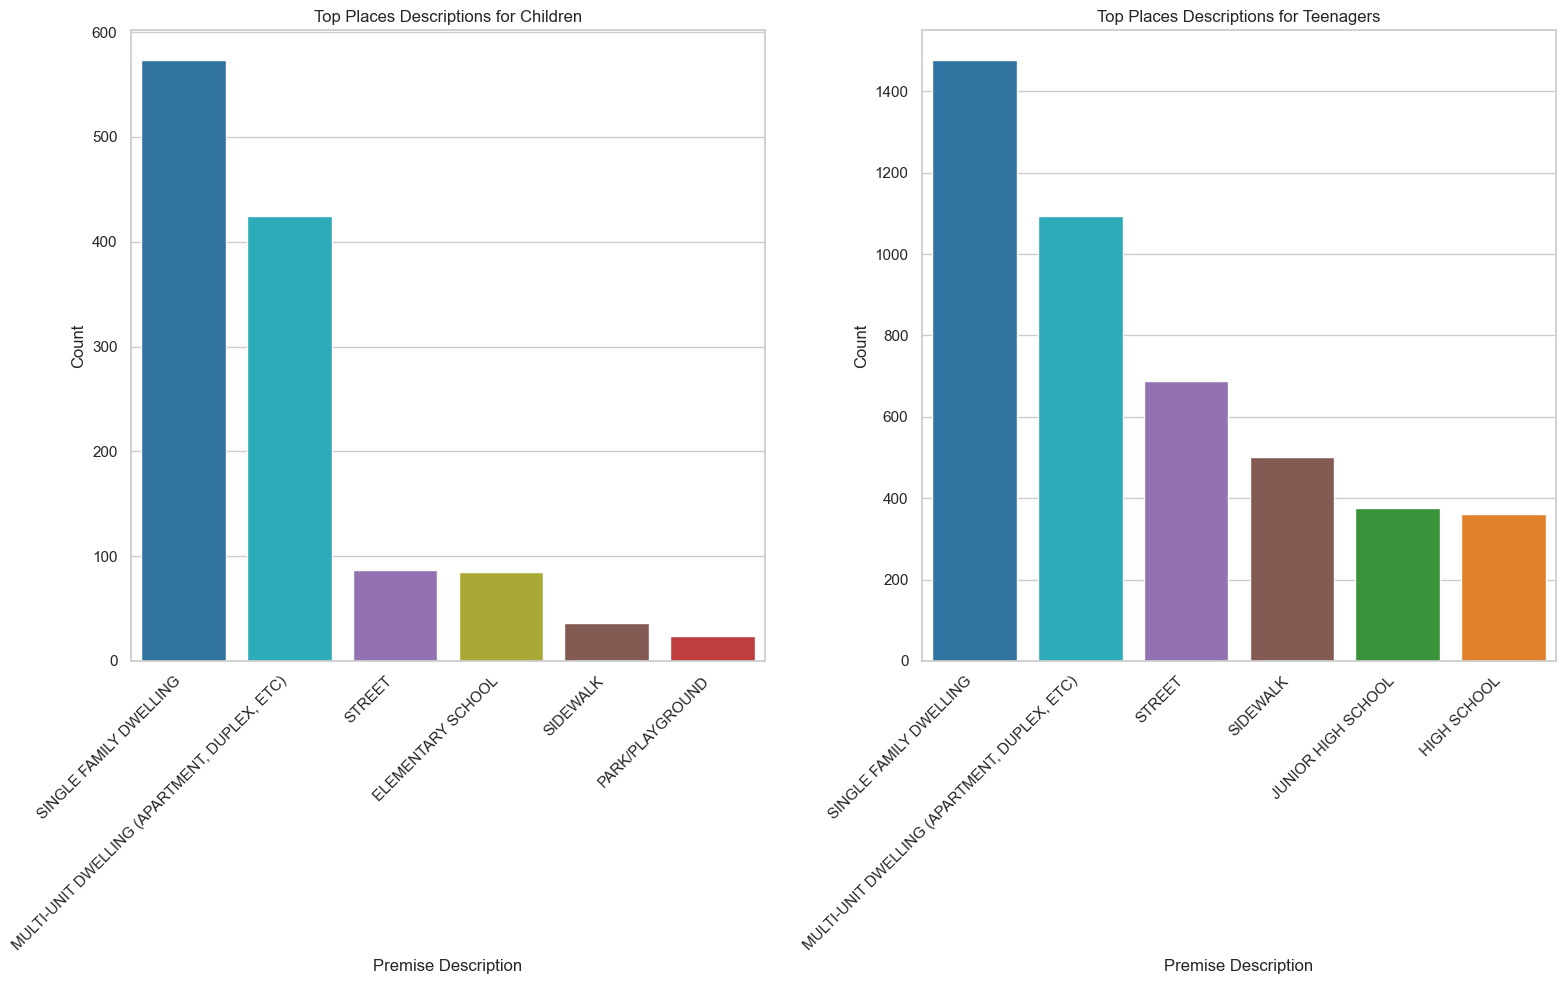

In [211]:
top_child_places = child_df_place_count.head(6)
top_teenager_places = teenager_df_place_count.head(6)


common_places = set(top_child_places['place_description']).intersection(set(top_teenager_places['place_description']))


custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#17becf', '#bcbd22']  # כחול, כתום, ירוק, אדום, סגול, חום, טורקיז, צהוב ירקרק
unique_places = list(set(top_child_places['place_description']).union(set(top_teenager_places['place_description'])))
color_mapping = {place: custom_palette[i % len(custom_palette)] for i, place in enumerate(unique_places)}


plt.figure(figsize=(16, 10))


plt.subplot(1, 2, 1)
sns.barplot(data=top_child_places, x='place_description', y='amount', palette=[color_mapping[place] for place in top_child_places['place_description']])
plt.xticks(rotation=45, ha="right")
plt.title('Top Places Descriptions for Children')
plt.xlabel('Premise Description')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.barplot(data=top_teenager_places, x='place_description', y='amount', palette=[color_mapping[place] for place in top_teenager_places['place_description']])
plt.xticks(rotation=45, ha="right")
plt.title('Top Places Descriptions for Teenagers')
plt.xlabel('Premise Description')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

ניתן להבחין שכאשר מדובר על פשעי אלימות ופשעי מין,בשתי קבוצות הגילאים שבשתי המקומות הראשונים מופיעים מקומות מגורים

##### ניצור עמודה חדשה שתעזור לנו להבין האם המקרים קרו במתחמי מגורים,בבית ספר, במקומות אחרים

In [212]:
residential_areas = [
    'SINGLE FAMILY DWELLING', 'MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)',
    'GROUP HOME', 'OTHER RESIDENCE', 'YARD (RESIDENTIAL/BUSINESS)',
    'CONDOMINIUM/TOWNHOUSE', 'MOBILE HOME/TRAILERS/CONSTRUCTION TRAILERS/RV\'S/MOTORHOME',
    'FOSTER HOME BOYS OR GIRLS*', 'PROJECT/TENEMENT/PUBLIC HOUSING', 'PORCH, RESIDENTIAL',
    'TRANSIENT ENCAMPMENT', 'SINGLE RESIDENCE OCCUPANCY (SRO\'S) LOCATIONS'
]

schools = [
    'HIGH SCHOOL', 'JUNIOR HIGH SCHOOL', 'ELEMENTARY SCHOOL',
    'SPECIALTY SCHOOL/OTHER', 'PRIVATE SCHOOL/PRESCHOOL', 'DAY CARE/CHILDREN*',
    'BUS, SCHOOL, CHURCH', 'COLLEGE/JUNIOR COLLEGE/UNIVERSITY', 'DAY CARE/ADULTS*',
    'TRADE SCHOOL (MEDICAL-TECHNICAL-BUSINESS)*', 'FRAT HOUSE/SORORITY/DORMITORY'
]




def categorize_premise(premise):
    if premise in residential_areas:
        return 'Residential Areas'
    elif premise in schools:
        return 'Schools'
    else:
        return 'Non-Residential and Non-Schools'

Under_age_18_df['where_did_it_happen'] = Under_age_18_df['premise_description'].apply(categorize_premise)
### בנינו פונקציה שבודקת האם המקרה קרה מתחם מגורים למשל סוגרי דירות למינהם 

In [213]:
Under_age_18_df_value_counts = Under_age_18_df['where_did_it_happen'].value_counts().reset_index()
Under_age_18_df_value_counts.columns = ['where_did_it_happen', 'count']
Under_age_18_df_value_counts

,where_did_it_happen,count
0,Residential Areas,3806
1,Non-Residential and Non-Schools,2429
2,Schools,974


C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\1868203719.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


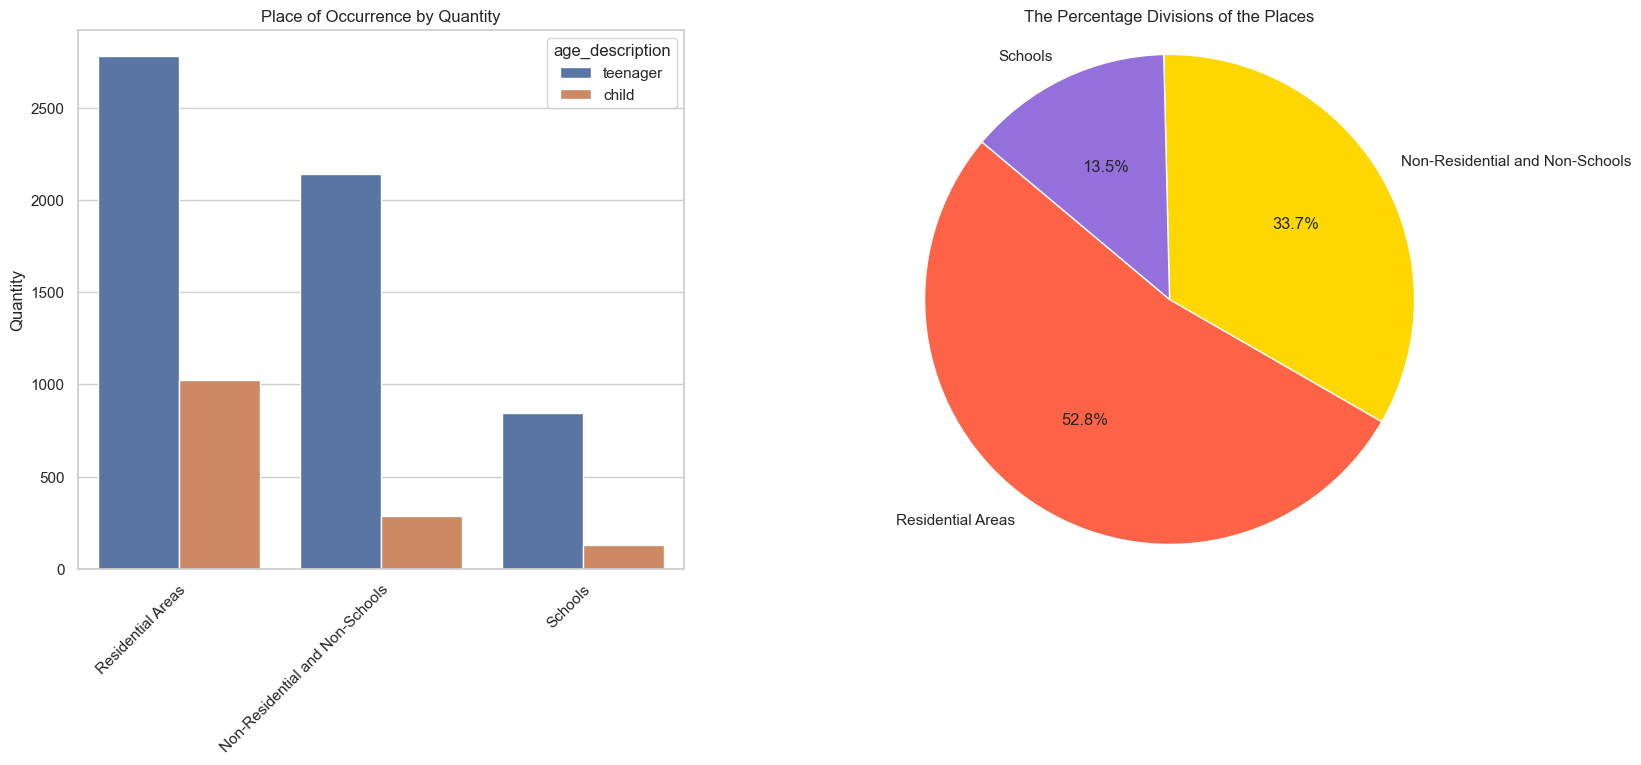

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))


sns.countplot(data=Under_age_18_df[Under_age_18_df['where_did_it_happen'] != 'Unknown'], hue='age_description', x='where_did_it_happen', order=Under_age_18_df_value_counts['where_did_it_happen'], ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax[0].set_title('Place of Occurrence by Quantity')
ax[0].set_xlabel('')
ax[0].set_ylabel('Quantity')


pie_data = Under_age_18_df['where_did_it_happen'].value_counts().reset_index()
pie_data.columns = ['where_did_it_happen', 'count']
colors = ['#FF6347', '#FFD700', '#9370DB']  # Matte red, yellow, and purple
ax[1].pie(pie_data['count'], labels=pie_data['where_did_it_happen'], autopct='%1.1f%%', startangle=140, colors=colors)
ax[1].set_title('The Percentage Divisions of the Places')
ax[1].axis('equal')


plt.subplots_adjust(wspace=0.3)
plt.show()

נתונים מדאיגים מצביעים על כך שגם עבור ילדים וגם עבור בני נוער המקומות שבהם הם הכי חשופים לאלימות הם דווקא בבית

In [215]:
all_population_df = df[df['crime_description'].isin(relevant_crimes)]
all_population_df['where_did_it_happen'] = all_population_df['premise_description'].apply(categorize_premise)

all_population_value_counts = all_population_df['where_did_it_happen'].value_counts().reset_index()
all_population_value_counts.columns = ['where_did_it_happen', 'count']
all_population_value_counts

C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\3409849938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_population_df['where_did_it_happen'] = all_population_df['premise_description'].apply(categorize_premise)


,where_did_it_happen,count
0,Non-Residential and Non-Schools,46887
1,Residential Areas,27489
2,Schools,1267


C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\3031056770.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_population_value_counts, x='where_did_it_happen', y='count', ax=axs[0, 0], palette=all_population_value_counts['color'].tolist())
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\3031056770.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\3031056770.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Under_age_18_df_value_co

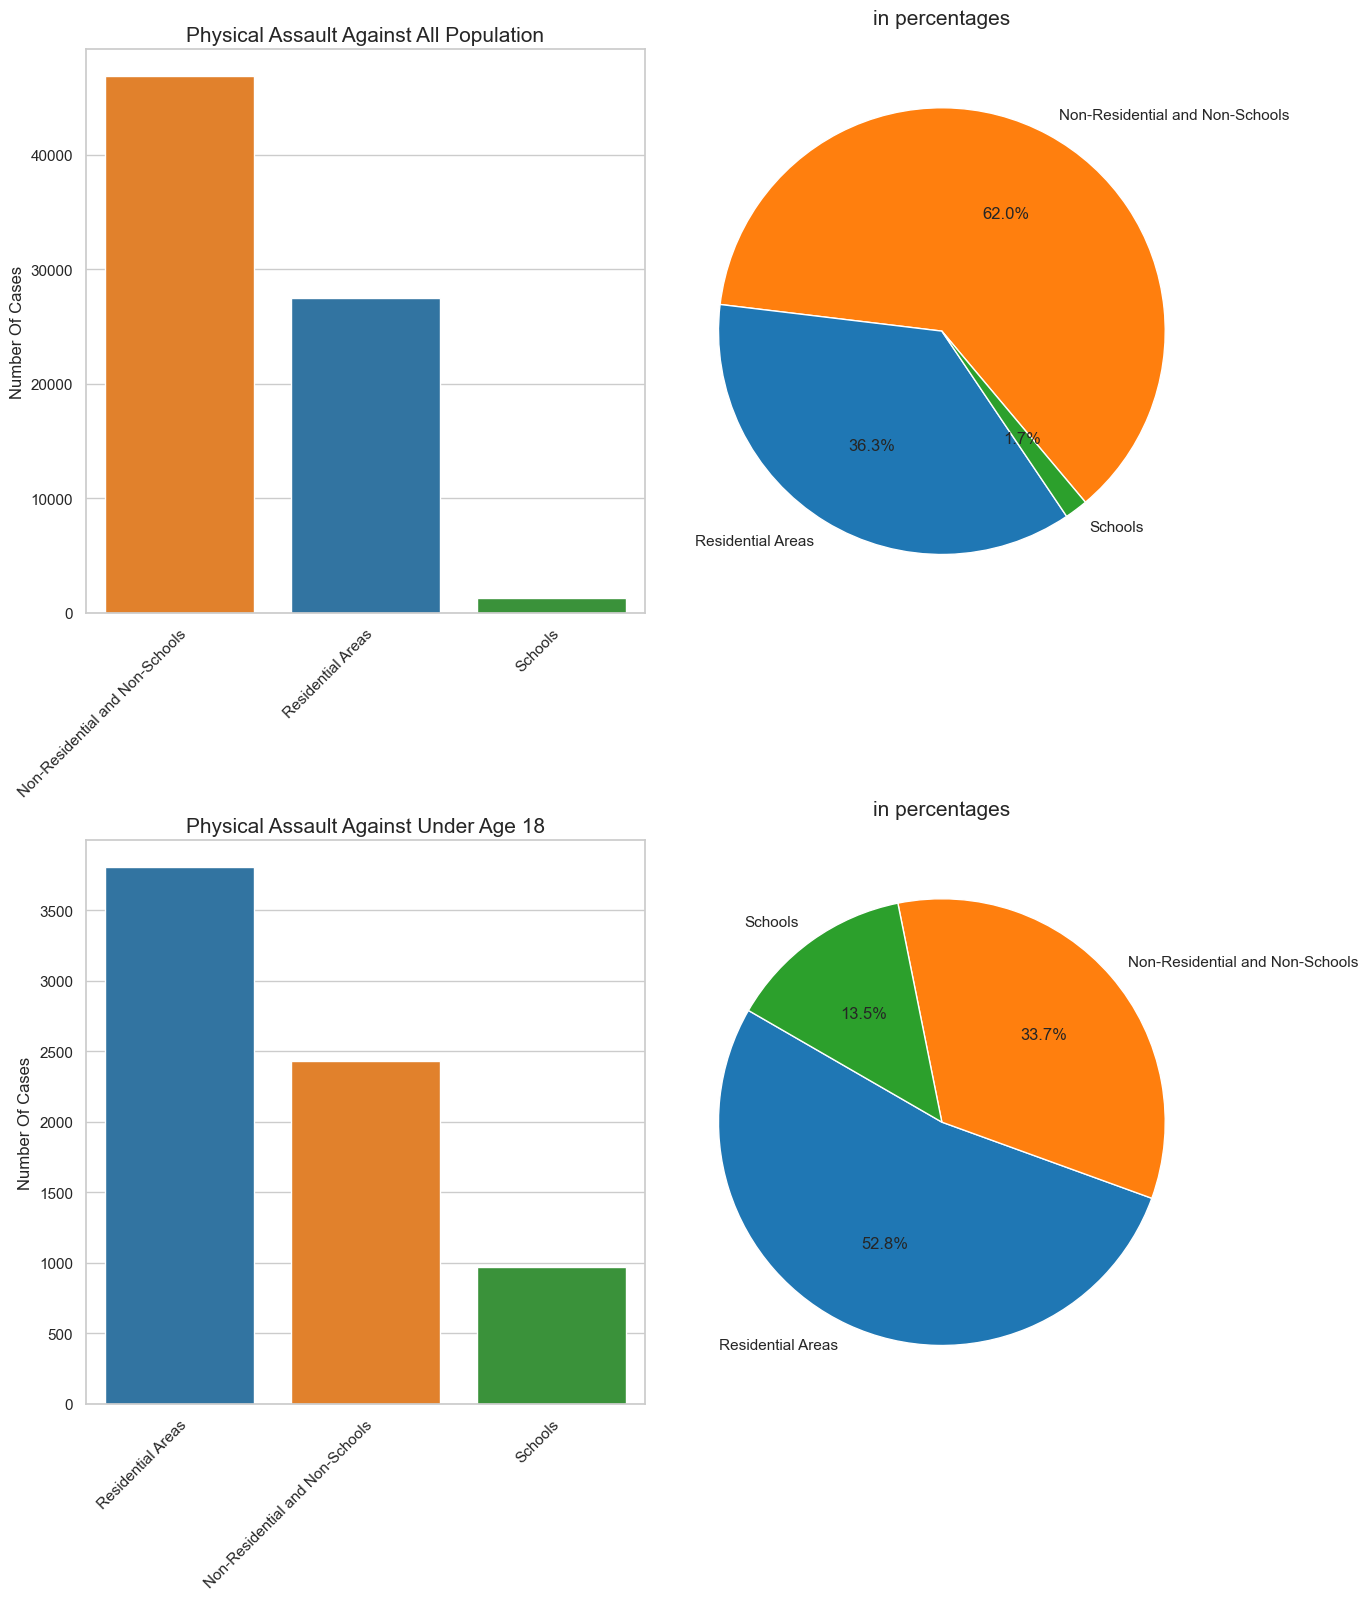

In [216]:
color_palette = {
    'Residential Areas': '#1f77b4',  # Blue
    'Non-Residential and Non-Schools': '#ff7f0e',  # Orange
    'Schools': '#2ca02c',  # Green
    'Unknown': '#d62728'  # Red
}

all_population_value_counts['color'] = all_population_value_counts['where_did_it_happen'].map(color_palette)
Under_age_18_df_value_counts['color'] = Under_age_18_df_value_counts['where_did_it_happen'].map(color_palette)


all_population_colors = [color_palette[label] for label in all_population_value_counts['where_did_it_happen']]
under_age_18_colors = [color_palette[label] for label in Under_age_18_df_value_counts['where_did_it_happen']]

fig, axs = plt.subplots(2, 2, figsize=(14, 16))


sns.barplot(data=all_population_value_counts, x='where_did_it_happen', y='count', ax=axs[0, 0], palette=all_population_value_counts['color'].tolist())
axs[0, 0].set_title('Physical Assault Against All Population', fontsize=15)
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Number Of Cases')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


axs[0, 1].pie(all_population_value_counts['count'], 
              labels=all_population_value_counts['where_did_it_happen'], 
              colors=all_population_colors, autopct='%1.1f%%', startangle=310)
axs[0, 1].set_title('in percentages', fontsize=15, pad=20)


sns.barplot(data=Under_age_18_df_value_counts, x='where_did_it_happen', y='count', ax=axs[1, 0], palette=Under_age_18_df_value_counts['color'].tolist())
axs[1, 0].set_title('Physical Assault Against Under Age 18', fontsize=15)
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Number Of Cases')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


axs[1, 1].pie(Under_age_18_df_value_counts['count'], 
              labels=Under_age_18_df_value_counts['where_did_it_happen'], 
              colors=under_age_18_colors, autopct='%1.1f%%', startangle=150)
axs[1, 1].set_title('in percentages', fontsize=15, pad=20)

plt.tight_layout()
plt.show()

ניתן לראות על פי הגרפים את ההבדלים כאשר מדובר על אלימות מתחת לגיל 18 רוב המקרם מתרחשים במתחמי מגורים ואילו כאשר מסתכלים על כלל האוכלוסייה רוב המקרים מתרחשים במרומות שהם לא מתחמי מגורים, וזה בא לידי ביטוי גם באחוזים

### גנבי זהות בהולנבק

In [229]:
identity_theft = df[df["crime_description"] == "THEFT OF IDENTITY"]




#### נעיף מבט על התפלגות הגילאים של הקורבנות

C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\1974408678.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=identity_theft, x='victim_age', palette='pastel')


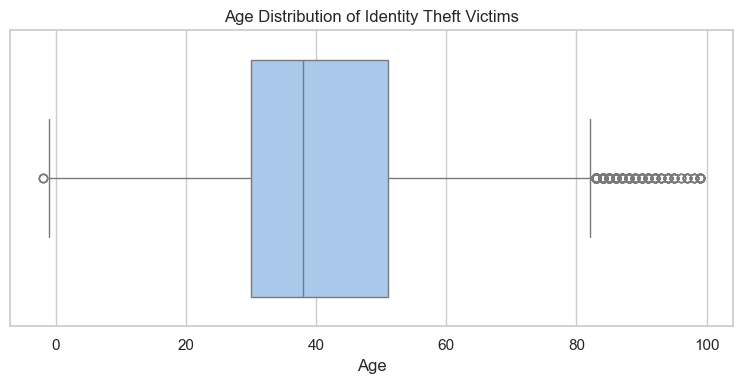

In [230]:
plt.figure(figsize=(15,4))


plt.subplot(1, 2, 1)
sns.boxplot(data=identity_theft, x='victim_age', palette='pastel')
plt.title('Age Distribution of Identity Theft Victims')
plt.xlabel('Age')
plt.tight_layout()
plt.show()

In [231]:
identity_theft_age0 = identity_theft[identity_theft['victim_age'] <= 0]
len(identity_theft_age0)


992

קיימים כ992 ערכים שהגיל שלהם הוא קטן או שווה ל 0 נבחר להשאיר אותם מכיוון שסביר שהמתלוננים בחרו להישאר בעילום שם או טעות בהקלדת הנתונים נבחר להשאירים כדי הם עדיין מקרים שקרו 

#### נבחן את אזורי הפשיעה הבהם נעשים פשעי גניבת הזהות

In [232]:
idt_by_area = identity_theft['area_name'].value_counts().reset_index()
idt_by_area.columns = ["area_name","amount"]



#### נבחן את המקומות הבהם נעשים פשעי גניבת הזהות

In [233]:
place_counts = identity_theft['premise_description'].value_counts().reset_index()
place_counts.columns = ['place', 'count']
place_counts.head()


,place,count
0,SINGLE FAMILY DWELLING,26250
1,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",12915
2,BANK,2452
3,AUTOMATED TELLER MACHINE (ATM),2205
4,CYBERSPACE,1592


#### נבדוק מה הם האיזורים שעושים שימוש במקומות שמתעסקים בכסף כדי לגנוב את זהות הקורבנות
נסווג את המקומות שמתעסקים בכסף, ונגנבים שם זהויות של אנשים

In [234]:
selected_premises = [
    "BANK DROP BOX/MONEY DROP-OUTSIDE OF BANK",
    "DRIVE THRU BANKING (WINDOW)",
    "BANKING INSIDE MARKET-STORE",
    "CHECK CASHING",
    "SAVINGS & LOAN",
    "FINANCE COMPANY",
    "CREDIT UNION",
    "AUTOMATED TELLER MACHINE (ATM)",
    "BANK"
]

idt = identity_theft[identity_theft['premise_description'].isin(selected_premises)]
idt_area_name = idt['area_name'].value_counts().reset_index()
idt_area_name.columns = ['area_name', 'amount']


C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\1537978483.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=idt_area_name, x='amount', y='area_name', ax=axs[0], palette=colors_area_name)
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\1537978483.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=idt_by_area, x='amount', y='area_name', ax=axs[1], palette=colors_by_area)


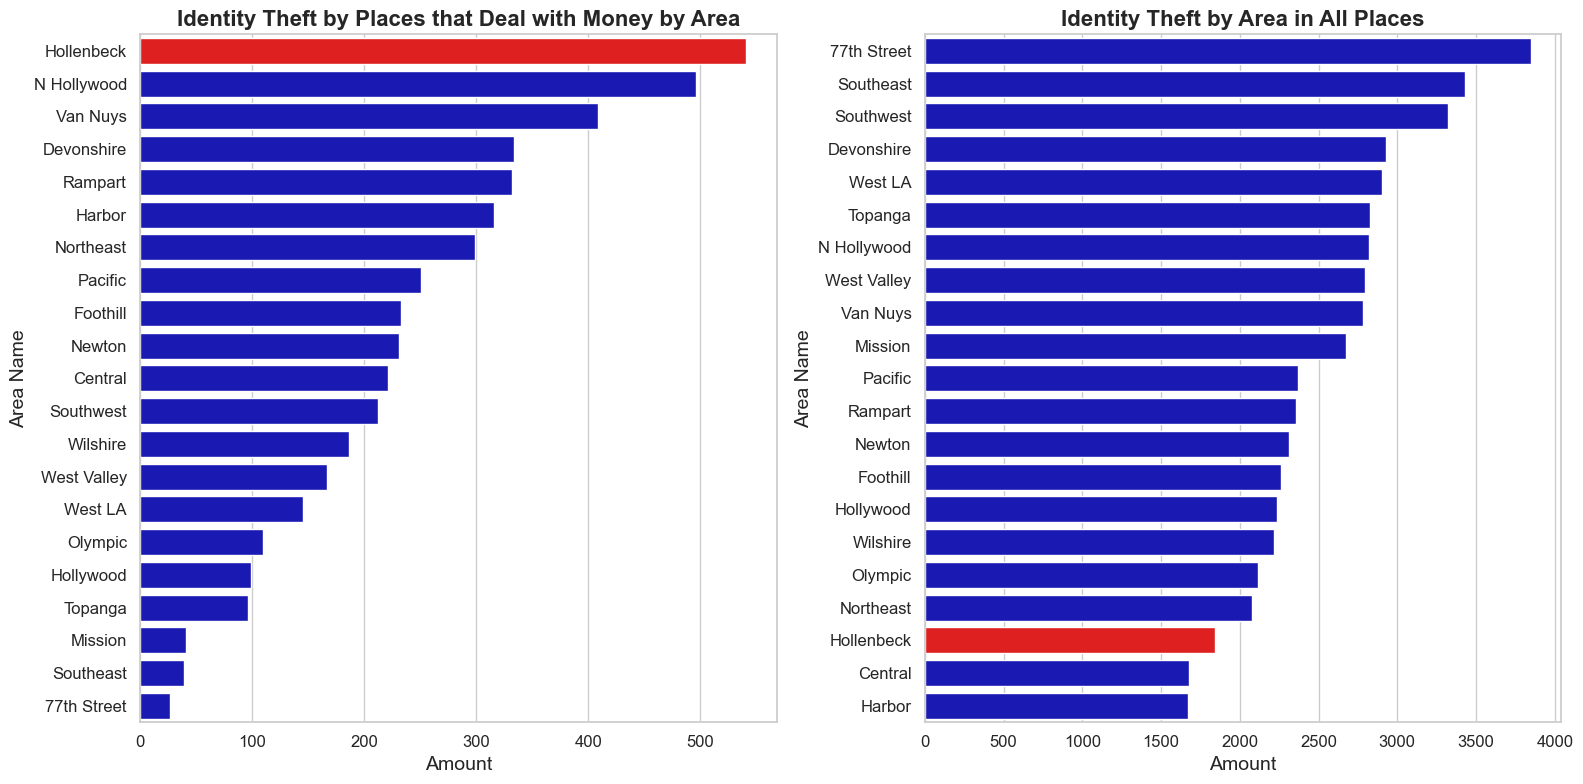

In [235]:
colors_area_name = ['#ff0000' if area == 'Hollenbeck' else '#0000cd' for area in idt_area_name['area_name']]
colors_by_area = ['#ff0000' if area == 'Hollenbeck' else '#0000cd' for area in idt_by_area['area_name']]


fig, axs = plt.subplots(1, 2, figsize=(16, 8))


sns.barplot(data=idt_area_name, x='amount', y='area_name', ax=axs[0], palette=colors_area_name)
axs[0].set_title('Identity Theft by Places that Deal with Money by Area', fontsize=16, weight='bold')
axs[0].set_xlabel('Amount', fontsize=14)
axs[0].set_ylabel('Area Name', fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)


sns.barplot(data=idt_by_area, x='amount', y='area_name', ax=axs[1], palette=colors_by_area)
axs[1].set_title('Identity Theft by Area in All Places', fontsize=16, weight='bold')
axs[1].set_xlabel('Amount', fontsize=14)
axs[1].set_ylabel('Area Name', fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()


plt.show()

###### נתון מפתיע הולנבק האזור שנמצא במקומות האחרונים (שלישי לפני הסוף) נמצא במקום הראשון שמדובר על פשעים שנעשו במקומות שמתעסקים בכסף

#### ננסה להבין מי האוכלוסייה שסובלת הכי הרבה מגנבי זהות במקומות שעיקר התעסוקתם זה כסף בהולנבק

In [236]:
idt_Hollenbeck = identity_theft[(identity_theft['premise_description'].isin(selected_premises)) & (identity_theft['area_name'] == 'Hollenbeck')]
idt_Hollenbeck_by_descent = idt_Hollenbeck['victim_descent'].value_counts().reset_index()
idt_Hollenbeck_by_descent.columns = ['victim_descent', 'amount']


C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\2037912202.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=custom_palette, ax=ax)
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\2037912202.py:6: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=custom_palette, ax=ax)
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\2037912202.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


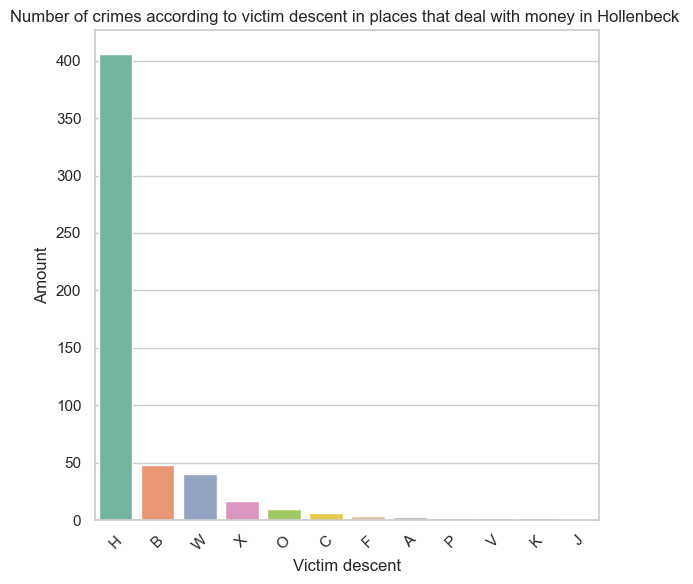

In [237]:
custom_palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(6, 6))


sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=custom_palette, ax=ax)

ax.set_title("Number of crimes according to victim descent in places that deal with money in Hollenbeck ")
ax.set_xlabel("Victim descent")
ax.set_ylabel("Amount")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

 ניתן לראות שבפער ניקר ההיספנים המסכנים סובלים הכי הרבה מהגניבות זהות במקמות  שעיקר התעסקותם זה כסף

In [249]:
idt_Hollenbeck['category'] = idt_Hollenbeck['victim_descent'].apply(lambda x: 'H' if x == 'H' else 'Everything Else')
idt_Hollenbeck_by_descent = idt_Hollenbeck['category'].value_counts().reset_index()
idt_Hollenbeck_by_descent.columns = ['victim_descent', 'amount']


C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\2773990762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idt_Hollenbeck['category'] = idt_Hollenbeck['victim_descent'].apply(lambda x: 'H' if x == 'H' else 'Everything Else')


In [251]:
idt_in_all_places_by_descent = identity_theft["victim_descent"].value_counts().reset_index()
idt_in_all_places_by_descent.columns = ["victim_descent", "amount"]
identity_theft['category'] = identity_theft['victim_descent'].apply(lambda x: 'H' if x == 'H' else 'Everything Else')

idt_in_all_places_by_descent = identity_theft['category'].value_counts().reset_index()
idt_in_all_places_by_descent.columns = ["victim_descent", "amount"]



C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\4263458413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identity_theft['category'] = identity_theft['victim_descent'].apply(lambda x: 'H' if x == 'H' else 'Everything Else')


,victim_descent,amount
0,Everything Else,35916
1,H,17551


C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\4287853674.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=colors_hollenbeck, ax=axes[0])
C:\Users\Win10\AppData\Local\Temp\ipykernel_11532\4287853674.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='victim_descent', y='amount', data=idt_in_all_places_by_descent, palette=colors_all_places, ax=axes[1])


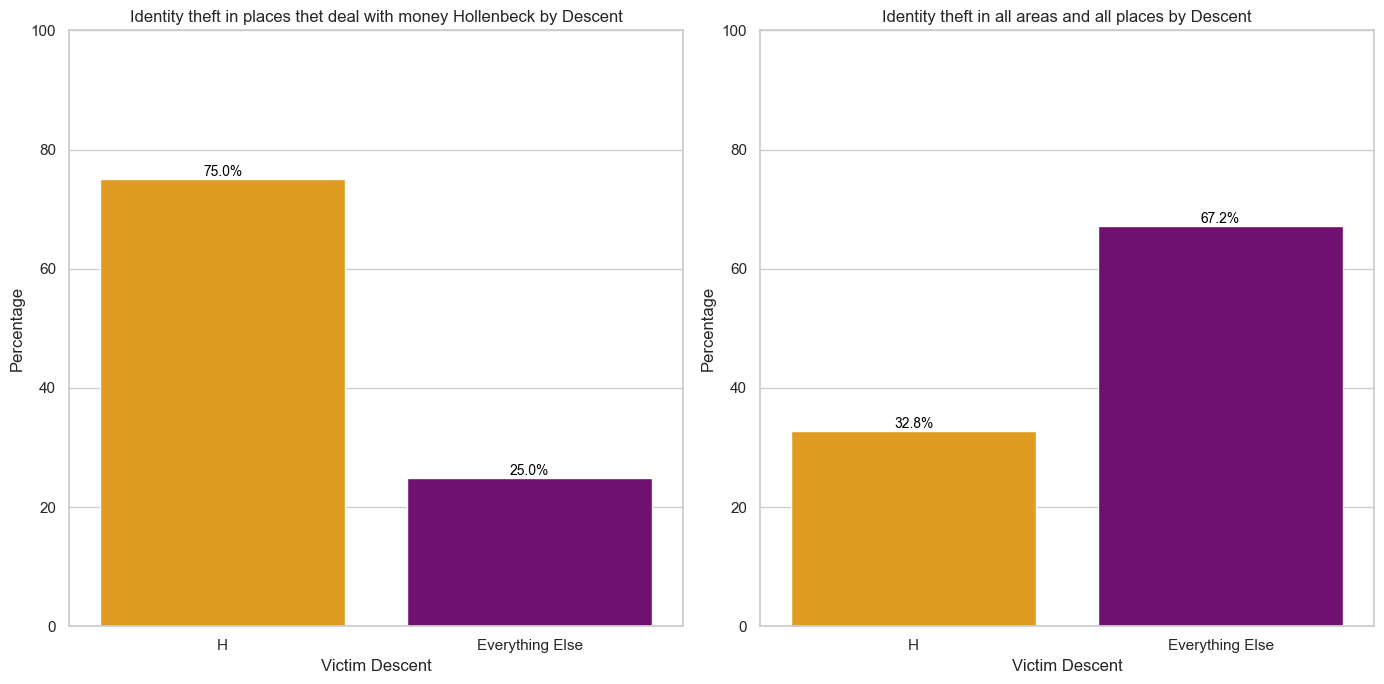

In [263]:
idt_Hollenbeck_by_descent['amount'] = (idt_Hollenbeck_by_descent['amount'] / idt_Hollenbeck_by_descent['amount'].sum()) * 100
idt_in_all_places_by_descent['amount'] = (idt_in_all_places_by_descent['amount'] / idt_in_all_places_by_descent['amount'].sum()) * 100


idt_in_all_places_by_descent = idt_in_all_places_by_descent.sort_values(by='victim_descent', ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 7))


colors_hollenbeck = ['orange' if descent == 'H' else 'purple' for descent in idt_Hollenbeck_by_descent['victim_descent']]
sns.barplot(x='victim_descent', y='amount', data=idt_Hollenbeck_by_descent, palette=colors_hollenbeck, ax=axes[0])
axes[0].set_title('Identity theft in places thet deal with money Hollenbeck by Descent')
axes[0].set_xlabel('Victim Descent')
axes[0].set_ylabel('Percentage')
axes[0].set_ylim(0, 100)


for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


colors_all_places = ['orange' if descent == 'H' else 'purple' for descent in idt_in_all_places_by_descent['victim_descent']]
sns.barplot(x='victim_descent', y='amount', data=idt_in_all_places_by_descent, palette=colors_all_places, ax=axes[1])
axes[1].set_title('Identity theft in all areas and all places by Descent')
axes[1].set_xlabel('Victim Descent')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)


for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### מסקנה 1

ניתן להבחין כי כאשר מדובר על פשעי גניבות הזהות באופן כללי האיזור הולנבק נמצא בין האיזורים שבהם כמות פשעי גניבות הזהות מהנמוכים ביותר
אך כאשר אנו מסתכלים על פשעי גניבות הזהות שנעשים במקומות ציבוריים שעיקר התעסקותם זה כסף (בנקים,כספומטים,חברות,אשראי וכו), הולנבק במקום הראשון
מבדיקה קצרה בגוגל, גילנו שבהולנבק שיעור העוני מהגבוהים בארצות הברית, כ33 אחוז נמאים מתחת לקו העוני וגם שההיספנים מהווים כ65 אחוז מכלל העניים בארצות הברית.
נתונים אלו יכולים להסביר את המגמת גניבות הזהות שאנו רואים במקומות ציבוריים שעיקר עיסוקיים זה כסף בהולנבק ,ההנחה שלנו היא שההיספנים שנמצאים שם מהווים "טרף קל"
לגנבי זהות עכב העובדה שרובם עניים קל יותר לפתה אותם למסור פרטיים אישים במקומות כמו בנקים כספומטים וגרומים אחרים שמתעסקים בכסף 

### פריצות לנכנסים של האוכלוסייה המבוגרת 

In [ ]:
old_df = df[df["age_description"]== "old"]

old_df_crime_description = old_df['crime_description'].value_counts().reset_index()
old_df_crime_description.columns = ['crime_description', 'count']

old_df_crime_description.head(20)


In [ ]:
old_burglary_df = old_df[old_df["crime_description"] == "BURGLARY"]
premise_description_counts = old_burglary_df['premise_description'].value_counts().reset_index()
premise_description_counts.columns = ['premise_description', 'count']
top_10_premise_descriptions = premise_description_counts.head(10)


fig, ax = plt.subplots(figsize=(12, 8))


colors = ['lightblue' if count != top_10_premise_descriptions['count'].max() else 'blue' for count in top_10_premise_descriptions['count']]


sns.barplot(x='premise_description', y='count', data=top_10_premise_descriptions, palette=colors, edgecolor='black', ax=ax)


ax.set_xlabel('Premise Description', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Top 10 Places Descriptions for Burglary Victims', fontsize=16, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)


ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

על פי הגרף נראה שרוב אכלוסיית הזקנים שנפגעת מפריצות,מדווחת על פריצות לביתהם. אם זאת ניתן לראות שקיימות גם פריצות לעסקים בתדירות נמוכה

##### נבדוק האם המשטרה מצליחה להקטין את הפריצות נגד האוכלוסייה המבוגרת 

In [ ]:
old_burglary_df['year_occurred'] = old_burglary_df['date_occurred'].dt.year
yearly_counts_old_burglary_df = old_burglary_df['year_occurred'].value_counts().reset_index()
yearly_counts_old_burglary_df.columns = ['year', 'amount_burglaries']
yearly_counts_old_burglary_df


In [ ]:
yearly_counts_old_burglary_df['year'] = yearly_counts_old_burglary_df['year'].astype(int)


fig, ax = plt.subplots(figsize=(5,5))


sns.barplot(x='year', y='amount_burglaries', data=yearly_counts_old_burglary_df, palette="Blues", edgecolor='black', ax=ax)


ax.set_xlabel('Year', fontsize=10, labelpad=20)
ax.set_ylabel('Amount of Burglaries', fontsize=10, labelpad=20)
ax.set_title('Yearly Amount of Burglaries Against an Elderly Population', fontsize=10, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)


ax.yaxis.get_major_locator().set_params(integer=True)


plt.tight_layout()
plt.show()

על פי הגרף ניתן להבחין במגמת עלייה מדאיגה בנושא פריצות נגד האוכלוסייה המבוגרת

##### ננסה להבין כמה פושעים שביצעו פריצות לנכנסים של אנשים מהאוכלוסייה המבוגרת נענשים

In [ ]:
status_description_counts = old_burglary_df['status_description'].value_counts().reset_index()
status_description_counts.columns = ['status_description', 'count']
status_description_counts

In [ ]:
invest_cont_count = status_description_counts[status_description_counts['status_description'] == "Invest Cont"]['count'].sum()
other_count = status_description_counts['count'].sum() - invest_cont_count

status_description_simplified = pd.DataFrame({
    'status_description': ['Invest Cont', 'The criminal was punished'],
    'count': [invest_cont_count, other_count]
})


fig, axes = plt.subplots(1, 2, figsize=(12, 6))


colors = ["#6495ED", "#FFD700"]
axes[1].pie(status_description_simplified['count'], labels=status_description_simplified['status_description'], autopct='%1.1f%%', colors=colors, startangle=140)
axes[1].set_title('Pie Chart of percentage distribution')
axes[1].axis('equal')


sns.barplot(x='status_description', y='count', data=status_description_counts, palette=colors, edgecolor='black', ax=axes[0])


axes[0].set_xlabel('Status Description')
axes[0].set_ylabel('Amount')
axes[0].set_title('Bar plot of status of the "Burglaries for elderly victims" investigation',fontsize=12, pad=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()

ניתן לראות על פי הגרפים שב91.6 אחוז מהמקרים בהם האוכלוסייה הזקנה מדווחת על פריצה, החקירה נמצאת במצב פתוח, משמע רוב הפורצים לא נעצרים. מבחינה כמותית מתוך 8426 מקרים בהם פרצו לבתים ועסקים של אנשים מעל גיל 60 כ7716 מקרים עדיין מוגדרים כמקרים פתוחים

##### נבדוק האם יש מגמת עלייה או ירידה ביחס הפושעים שנענשו במהלך השנים

In [ ]:
status_description_yearly_counts = old_burglary_df.groupby(['year_occurred', 'status_description']).size().reset_index(name='count')


pivot_table = status_description_yearly_counts.pivot(index='year_occurred', columns='status_description', values='count').fillna(0)


pivot_table

In [ ]:
required_columns = ['Adult Arrest', 'Adult Other', 'Juv Arrest']
for col in required_columns:
    if col not in pivot_table.columns:
        pivot_table[col] = 0


result_df = pivot_table.reset_index()
result_df['The criminal was punished'] = result_df[required_columns].sum(axis=1)
result_df = result_df[['year_occurred', 'Invest Cont', 'The criminal was punished']]


result_df = result_df.fillna(0)

result_df.columns = ['Year', 'Invest Cont', 'criminals_punished']
result_df

In [ ]:
result_df = pivot_table.reset_index()
result_df['The criminal was punished'] = result_df[required_columns].sum(axis=1)
result_df = result_df[['year_occurred', 'Invest Cont', 'The criminal was punished']]


result_df = result_df.fillna(0)
result_df.columns = ['year', 'Invest Cont', 'criminals_punished']
result_df

In [ ]:
result_subset = result_df[['criminals_punished', 'year']]
yearly_counts_subset = yearly_counts_old_burglary_df[['amount_burglaries', 'year']]


final_df = pd.merge(result_subset, yearly_counts_subset, on='year')


final_df = final_df[['year', 'amount_burglaries', 'criminals_punished']]
final_df


##### נבדוק את הקורלציה בין עליית כמות הפריצות עם כמות ירידת הפורצים שנתפסו בשנים האחרונות

In [ ]:
correlation_data = final_df[['criminals_punished', 'amount_burglaries']]
correlation_matrix = correlation_data.corr()


plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap between Number of Criminals Punished and Amount of Burglaries', fontsize=10 , pad=25)
plt.show()






בהתאם לנתוני הקורלציה, ניתן להסיק כי קיימת מגמה לפיה ככל שמספר העבריינים שנענשים הולך ודועך, כך מספר הפריצות הולך ועולה. קשר זה, שמוערך ב-0.85-, מצביע על קשר שלילי חזק בין שני המקרים

In [ ]:
sns.set_theme(style="whitegrid")


final_df['year'] = final_df['year'].astype(int)
result_df['year'] = result_df['year'].astype(int)


plt.figure(figsize=(8, 6))


sns.lineplot(x='year', y='amount_burglaries', data=final_df, color='red', marker='o', linestyle='-', linewidth=2, markersize=6, label='Yearly amount of Burglaries against an elders population')
sns.lineplot(x='year', y='criminals_punished', data=result_df, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6, label='Criminals punished')

plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.title('Yearly amount of Burglaries against an elders population and Criminals punished', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### מסקנה 2 

על פי החקירה שחברי הצוות עשו בנושא "פריצות לנכסים של האוכלוסייה המבוגרת" לראות כי בשנים האחרונות חלה עלייה בכמות עבירות הפריצה שנעשות נגד אנשים בני 60 ומעלה,
ומנגד חלה ירידה בכמות הפושעים שנענשו על העבירה. הנתונים הללו שמרבית הפורצים לא נענשים מצבעים על מגמת ירידה של המשטרה בלוס אנג'לס בנושא הזה, מה שנותן לפורצים לגטימציה  להמשיך ולבצע פריצות לנכנסים של האוכלוסייה המבוגרת. המשטרה בלוס אנג'לס חייבת לשים יותר דגש על לכידת פורצים שפורצים לנכנסים של אוכלוסיית האנשים מגיל 60 ומעלה
מכייון שעל פי הקורלציה השלילית החזקה שיש בין המקרים, ככל שכמות  העונשים לפורצים שפרצו לנכנסים של אנשים מגיל 60 ומעלה תגדל, כך תגדל גם כמות הפריצות נגד אותה אוכלוסייה תקטן , ולכן חובת המשטרה היא לעצור את כמה שיותר פורצים כאלו על מנת לתת הרתעה לפורצים, ולתת תחושת ביטחון לאוכלוסייה המבוגרת

### שימוש בנשק חם ברחוב 77

In [ ]:
firearm_df = df[df["weapon_category"] == "firearm"] 
sharp_weapon_df = df[df["weapon_category"] == "Physical strength"]

area_name_counts = firearm_df['area_name'].value_counts().reset_index()

area_name_counts.columns = ['area_name', 'count']





In [ ]:
palette = sns.color_palette("tab20", len(area_name_counts))


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(6,6))


bar_plot = sns.barplot(data=area_name_counts, y='area_name', x='count', palette=palette, ax=ax)


ax.set_title('Count of Firearm Incidents by Area Name')
ax.set_xlabel('Count')
ax.set_ylabel('Area Name')

plt.show()

ניתן לראות שהאיזור הכי בעייתי מבחינת פשעים שבצעו מבחינת נשק חם הוא רחוב 77 נתמקד בו

נבדוק מה המקומות בהם נעשים הכי הרבה פעשים בעזרת שימוש בנשק חם רחוב 77

In [ ]:
th77_firearm_df = firearm_df[firearm_df["area_name"] =="77th Street"]
premise_description_counts = th77_firearm_df['premise_description'].value_counts().reset_index()
premise_description_counts.columns = ['premise_description', 'count']
premise_description_counts.head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))


palette = sns.color_palette("viridis", n_colors=10)
sns.barplot(x='premise_description', y='count', data=premise_description_counts.head(10), ax=ax, palette=palette)


ax.set_title('Top 10 Places by Amount')
ax.set_xlabel('')
ax.set_ylabel('Amount')


plt.xticks(rotation=45,ha = "right")


plt.show()

נניתן לראות שבפער ניקר מהמקום השני הכי הרבה פשעים ששומשו בעזרת נשק חם קרו ברחוב 

ניצור עמודה חדשה שתתן שתיתן לנו מידע האם הפשע בוצע במקום ציבורי או פרטי

In [ ]:
public_places = [
    'TRAIN TRACKS',
    'TOW YARD',
    'OTHER/OUTSIDE',
    'TUNNEL',
    'VACANT LOT',
    'SWAP MEET',
    'FREEWAY',
    'SHOPPING MALL (COMMON AREA)',
    'PARK/PLAYGROUND',
    'MARKET',
    'BUS STOP',
    'GAS STATION',
    'ALLEY',
    'PARKING LOT',
    'SIDEWALK',
    'STREET',
    "TRANSIENT ENCAMPMENT",
]


th77_firearm_df['public_or_private'] = th77_firearm_df['premise_description'].apply(lambda x: 'public place' if x in public_places else 'private place')


In [ ]:
public_private_counts = th77_firearm_df['public_or_private'].value_counts().reset_index()
public_private_counts.columns = ["public_or_private", "count"]
public_private_counts

In [ ]:
colors = sns.color_palette("pastel")[0:2]


fig, axes = plt.subplots(1, 2, figsize=(10,6))


sns.barplot(x='public_or_private', y='count', data=public_private_counts, ax=axes[0], palette=colors)
axes[0].set_title('Public vs Private Places Amount')
axes[0].set_xlabel('')
axes[0].set_ylabel('Amount')


axes[1].pie(public_private_counts['count'], labels=public_private_counts['public_or_private'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Percentage Distribution')


plt.tight_layout()
plt.show()

כמו שחשבנו בפער ניכר השימוש בנשק לצרוך ביצוע עיברות, גדול בהרבה כאשר הפשע מתבצע במקומות ציבוריים

נבדוק מה קרה עם פשעים שבוצעו בעזרת נשק חם לאורך השנים

ניתן להבין על פי הגרף שהמשטרה ברחוב 77 עושה עבודה מעולה ואכן מצליחה להוריד את כמות הפשעים משנה לשנה

In [ ]:
area_year_counts = th77_firearm_df.groupby(['public_or_private', 'year_occurred']).size().reset_index(name='count')




In [ ]:
public_counts = area_year_counts[area_year_counts['public_or_private'] == 'public place'][['year_occurred', 'count']].rename(columns={'count': 'amount_public'})
private_counts = area_year_counts[area_year_counts['public_or_private'] == 'private place'][['year_occurred', 'count']].rename(columns={'count': 'amount_private'})


merged_counts = pd.merge(public_counts, private_counts, on='year_occurred', how='outer')


merged_counts.fillna(0, inplace=True)


correlation_matrix = merged_counts[['amount_public', 'amount_private']].corr()


plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)


plt.title('Correlation Heatmap')


plt.show()


הקורלציה החזקה והשלילית מסבירה את הקשר החזק שבין הפשעים שבוצעו בעזרת שימוש בנשק חם בשכונת 77 במקומות ציבוריים לבין אלה שבוצעו במקומות פרטיים

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))


sns.lineplot(data=area_year_counts, x='year_occurred', y='count', hue='public_or_private', marker='o', ax=ax)


ax.set_title('Number of Cases by Year in Public and Private Places')
ax.set_xlabel('')
ax.set_ylabel('Number of Cases')


ax.set_xticks(area_year_counts['year_occurred'].unique())
ax.set_xticklabels(area_year_counts['year_occurred'].unique(), rotation=45)


plt.show()

#### מסקנה 3

ניתן להסיק כי בשנים באחרות ישנה ירידה בכמות הפשעים נעשים תוך כדי שימוש בנשק חם בפשעים שנעשים במקומות ציבוריים בשכונה 77, אך מנגד כמות הפשעים שמבוצעים באמצעות נשק חם במקומות הפרטיים בשכונה נשאר במצב יחסית סטטי, אפילו נחל עלייה מינורית אנו סבורים שהמשטרה משקיעה את מירב המאמצים בפשעים שמתבצעים במקומות ציבוריים וברחובות, ופחות מתמקדת במקומות הפרטיים, מה שמשאיר את הכמות במצב יחסית סטטי

### כיוסים בלוס אנג'לס

In [ ]:
chipopo_df = df[df["crime_description"] == "PICKPOCKET"]



In [ ]:
area_name_counts = chipopo_df['area_name'].value_counts().reset_index()
area_name_counts.columns = ['area_name', 'count']
area_name_counts

In [ ]:
colors = ['red' if area in ['Central', 'Hollywood'] else 'skyblue' for area in area_name_counts['area_name']]

# Create a bar plot for all area names with highlighted areas
plt.figure(figsize=(14, 8))
sns.barplot(x='count', y='area_name', data=area_name_counts, palette=colors)

plt.title('Pickpocket by Area Name')
plt.xlabel('Amount')
plt.ylabel('Area Name')
plt.tight_layout()

# Show the plot
plt.show()

ניתן לראות שסנטרל והוליווד שיודעים כאזורים היותר מתויירים של לוס אנג'לס מובילים את הרשימה נתמקד בהם

In [ ]:
CentralANDHollywood_df = chipopo_df[chipopo_df['area_name'].isin(['Central', 'Hollywood'])]
hour_counts_ch = CentralANDHollywood_df['hour_occurred'].value_counts().reset_index()
hour_counts_ch.columns = ['hour_occurred', 'count']

In [ ]:
custom_order = list(range(7, 24)) + list(range(0, 7))


hour_counts_ch['hour_occurred'] = pd.Categorical(hour_counts_ch['hour_occurred'], categories=custom_order, ordered=True)
hour_counts_ch = hour_counts_ch.sort_values('hour_occurred').reset_index(drop=True)


colors = ['coral' if (hour >= 22 or hour <= 1) else 'skyblue' for hour in custom_order]


fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=hour_counts_ch['hour_occurred'].astype(str), y=hour_counts_ch['count'], palette=colors, ax=ax)


hour_labels = [f'{hour:02d}:00' for hour in custom_order]


ax.set_xticks(range(len(custom_order)))
ax.set_xticklabels(hour_labels, rotation=45)

ax.set_xlabel('')
ax.set_ylabel('Amount')
ax.set_title('Pickpocket by Hour in Central & Hollywood')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

ניתן לראות בשעות הערב בעיקר האלה השעות בהם הכייסים פועלים בהוליווד וסנטרל

In [ ]:
day_of_week_counts = CentralANDHollywood_df['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['day_of_week', 'count']
day_of_week_counts

In [ ]:
if 'day_of_week' not in CentralANDHollywood_df.columns:
    CentralANDHollywood_df['day_of_week'] = CentralANDHollywood_df['date_occurred'].dt.day_name()

custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_of_week_counts['day_of_week'] = pd.Categorical(day_of_week_counts['day_of_week'], categories=custom_order, ordered=True)
day_of_week_counts = day_of_week_counts.sort_values('day_of_week').reset_index(drop=True)


highlight_days = ['Wednesday', 'Thursday', 'Friday', 'Saturday']
colors = ['coral' if day in highlight_days else 'skyblue' for day in day_of_week_counts['day_of_week']]


plt.figure(figsize=(12, 6))


sns.lineplot(x='day_of_week', y='count', data=day_of_week_counts, marker='o', color='skyblue')


sns.lineplot(x='day_of_week', y='count', data=day_of_week_counts[day_of_week_counts['day_of_week'].isin(highlight_days)], marker='o', color='coral')

plt.title('Occurrences by Day of the Week in Central & Hollywood')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

ניתן לראות שהעלייה מתחילה לקראת הסופש וכאשר הסופש נגמר מתחילה ירידה בעמות הכיוסים

In [ ]:
premise_description_counts = CentralANDHollywood_df['premise_description'].value_counts().reset_index()
premise_description_counts.columns = ['premise_description', 'count']
premise_description_counts.head(10)

In [ ]:
top_5_premise_description_counts = premise_description_counts.head(5)


plt.figure(figsize=(12, 6))
sns.barplot(x='premise_description', y='count', data=top_5_premise_description_counts, palette='viridis')

plt.title('Top Pickpocket Places')
plt.xlabel('')
plt.ylabel('Amount')
plt.xticks(rotation=45,ha = "right")
plt.tight_layout()


plt.show()

כפי חשבנו המקומות המובילים בהם קוראים כיוסים אלה מקומות בילוי

ניצור עמודה חדשה שתעזור לנו לבין כמה מקרים קרו במוקומת בילוי 

In [ ]:
hang_out_places = [
    'STAPLES CENTER *', 'BAR/COCKTAIL/NIGHTCLUB',
    'SHOPPING MALL (COMMON AREA)', 'DISCOUNT STORE (99 CENT,DOLLAR,ETC.',
    'BEACH', 'BAR/SPORTS BAR (OPEN DAY & NIGHT)', 'RESTAURANT/FAST FOOD',
    'COLISEUM', 'MINI-MART', 'NIGHT CLUB (OPEN EVENINGS ONLY)', 'THE GROVE',
    'CLOTHING STORE', 'CONVENTION CENTER', 'DEPARTMENT STORE',
    "COFFEE SHOP (STARBUCKS, COFFEE BEAN, PEET'S, ETC.)", 'LIQUOR STORE',
    'SPORTS VENUE, OTHER', 'THEATRE/MOVIE', 'SPORTS ARENA',
    'ENTERTAINMENT/COMEDY CLUB (OTHER)', 'MEMBERSHIP STORE (COSTCO,SAMS CLUB)*',
    "DIY CENTER (LOWE'S,HOME DEPOT,OSH,CONTRACTORS WAREHOUSE)", 'THE BEVERLY CONNECTION',
    'DODGER STADIUM', 'HOTEL', '*', 'MUSEUM', 'AMUSEMENT PARK*',
    'YARD (RESIDENTIAL/BUSINESS)', 'MASS GATHERING LOCATION',
    "SEX ORIENTED/BOOK STORE/STRIP CLUB/GENTLEMAN'S CLUB", 'OPTICAL OFFICE INSIDE STORE OR SUPERMARKET*'
]


CentralANDHollywood_df['hang-out place'] = CentralANDHollywood_df['premise_description'].isin(hang_out_places)

In [ ]:
CentralANDHollywood_df['hangout_category'] = CentralANDHollywood_df['hang-out place'].apply(lambda x: 'hangout place' if x else 'other')


fig, ax = plt.subplots(figsize=(8,8))


sns.countplot(data=CentralANDHollywood_df, x='area_name', hue='hangout_category', ax=ax, palette='bright')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_title('')
ax.set_xlabel('Area Name')
ax.set_ylabel('Quantity')

plt.show()












ניתן לראות שגם בסנטרל וגם בהולוויד רוב המקרים קורים בעיקר במקומות בילוי

נבדוק מה קרה במהלך השנים בנוגע לכייסים בהולוויד וסנטרל

In [ ]:
grouped_df= CentralANDHollywood_df.groupby(['area_name', 'year_occurred']).size().reset_index(name='count')

plt.figure(figsize=(10,8))


for area in grouped_df['area_name'].unique():
    area_data = grouped_df[grouped_df['area_name'] == area]
    plt.plot(area_data['year_occurred'], area_data['count'], marker='o', label=area)


plt.xlabel('Year')
plt.ylabel('Aount')
plt.title('Amount of Pickpockt by Year in Hollywood And Central')
plt.xticks(grouped_df['year_occurred'].unique())  
plt.legend(title='Area')


plt.grid(True)
plt.show()

ניתן לראות עלייה בכמות הכיוסים בשתי המקומות בין השנים 2020 ל2022 , אם זאת נראה שבהולוויד ישנה ירידה משנת 2022 ל2023, לעומת סנטרל ששם יש עלייה גם בין שנים האלה

In [ ]:
status_description_counts = CentralANDHollywood_df["status_description"].value_counts().reset_index()
status_description_counts.columns = ['status_description', 'count']


In [ ]:
status_description_counts['percentage'] = (status_description_counts['count'] / status_description_counts['count'].sum()) * 100

# יצירת גרף הפאי ללא אחוזים על הדיאגרמה עצמה
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts = ax.pie(status_description_counts['percentage'], startangle=90, colors=sns.color_palette("pastel"))

# הוספת אגדה (legend) עם תוויות והאחוזים
legend_labels = [f'{desc}: {pct:.1f}%' for desc, pct in zip(status_description_counts['status_description'], status_description_counts['percentage'])]
ax.legend(wedges, legend_labels, title="Status Description", loc="center left", bbox_to_anchor=(1, 0.5, 0.5, 1))

# כותרת
ax.set_title('The state of pickpocket investigations in Hollywood')

# הצגת הגרף
plt.show()

#### מסקנה 4


אף על פי שהמגמה ברורה ומירב הכיסיום שקוראים בהולוויד ובסנטרל מתרחשים ברובם בסופי שבוע ובמקומות מרכזיים בעיקר בין השעון 22:00 ל1:00 בלילה,בסנטרל מקרי הכיוס עולים משנה לשנה בניגוד להווליד שהצליחה לבלום את העלייה ולהוריד את הכמות לאחר שנת 2022. אם זאת נראה שבשתי תחנות המשטרה של איזורים אלה לא מייחסים יותר מידי חשיבות למקרי כיוס ומתוך 1049 מקרי כיוס שקרו בשתי האיזורים, רק 4 פושעים נתפסו נתון שמהווה פחות מחצי אחוז מכמות המקרים 